# FOIL Project 4: Overcoming catastrophic forgetting in neural networks.

[This paper](https://arxiv.org/pdf/1612.00796.pdf), by James Kirkpatrick et al., studies the setting of continual learning, where an agent learns multiple tasks sequentially, i.e., accumulating knowledge for a new task/experience without having access to data from past tasks. In this setting, the phenomenon of catastrophic forgetting arises; the performance of the agent on past experiences significantly diminishes upon learning new tasks. The paper proposes the use of a regularization term to combat this problem. We suggest steering from the reinforcement learning experience and, instead, focus on supervised learning. Reproduce the results of Figure 2 (subfigures A + B) on the following datasets: PermutedMNIST (as in the paper) as well as RotatedMNIST (ten tasks of rotating MNIST, where task i is produced by a fixed rotation of 10(i − 1) degrees). Compare the results of the proposed regularization with naive L2 regularization and no regularization.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

### Load the data:

Create three tasks of permuted MNIST

In [2]:
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

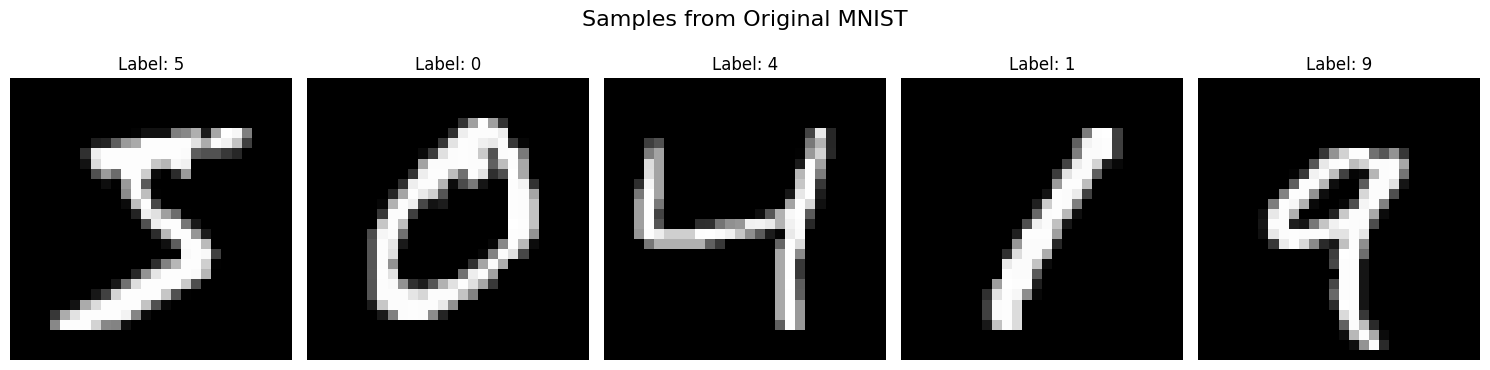

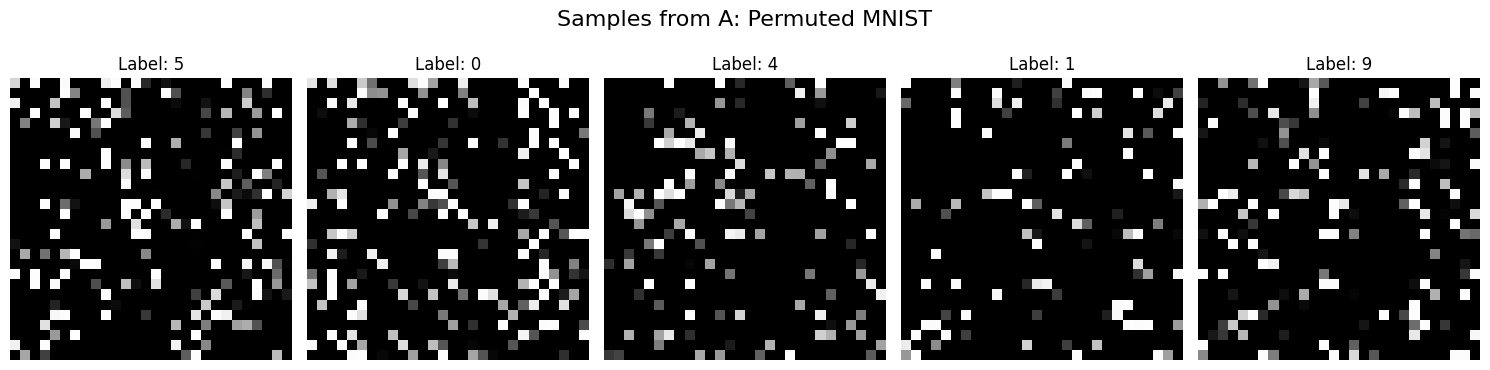

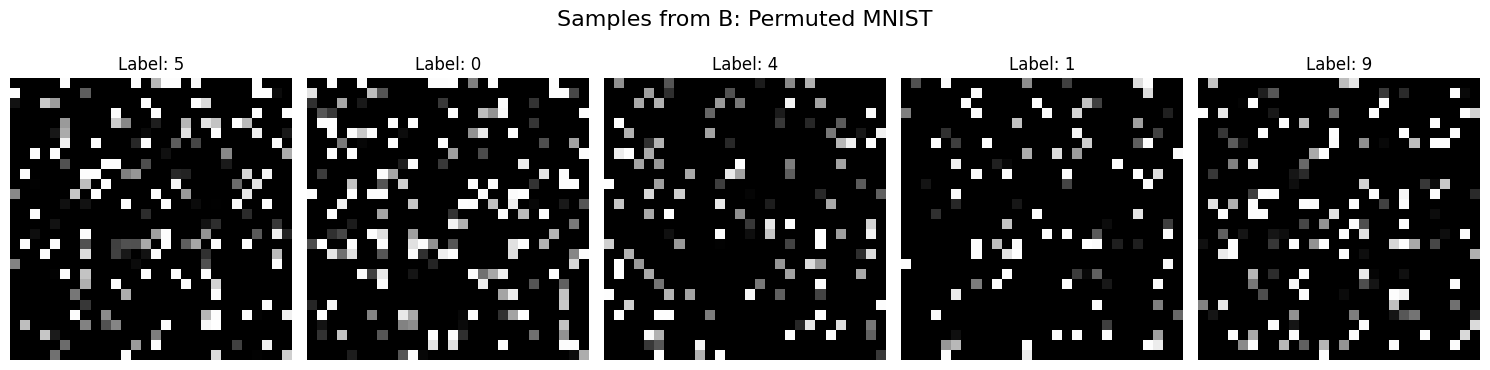

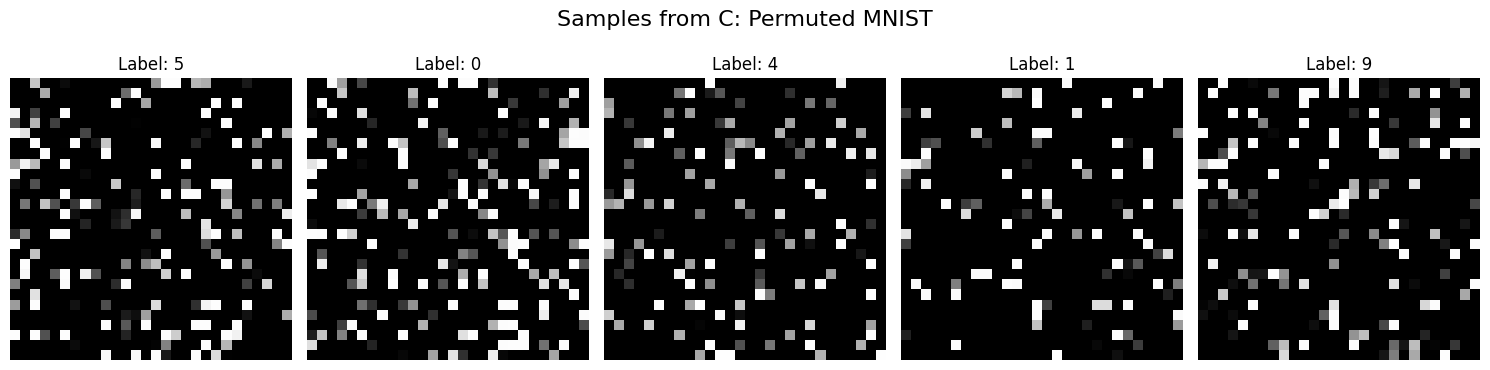

In [33]:
Task = namedtuple("Task", ["name", "train", "test"])

def create_permuted_mnist(rng):
    """
    Create a permuted MNIST dataset for a given task ID using a shared random number generator.
    """
    perm = torch.tensor(rng.permutation(28 * 28), dtype=torch.long)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1)[perm].view(1, 28, 28))
    ])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    return train_dataset, test_dataset

# Fix a single seed
seed = 42
rng = np.random.RandomState(seed)

# Create permuted tasks
Original_MNIST = Task(name="Original MNIST", train=mnist_train, test=mnist_test)
perm_tasks = [
    Task(name="A: Permuted MNIST", train=create_permuted_mnist(rng)[0], test=create_permuted_mnist(rng)[1]),
    Task(name="B: Permuted MNIST", train=create_permuted_mnist(rng)[0], test=create_permuted_mnist(rng)[1]),
    Task(name="C: Permuted MNIST", train=create_permuted_mnist(rng)[0], test=create_permuted_mnist(rng)[1])
]

for task in [Original_MNIST] + perm_tasks:
    loader = DataLoader(task.train, batch_size=5, shuffle=False)
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 4))
    for j in range(5):
        axes[j].imshow(images[j].squeeze(0), cmap="gray")
        axes[j].set_title(f"Label: {labels[j].item()}")
        axes[j].axis("off")
    
    fig.suptitle(f"Samples from {task.name}", fontsize=16)
    fig.tight_layout()

    plt.show()


Create rotated MNIST datasets:

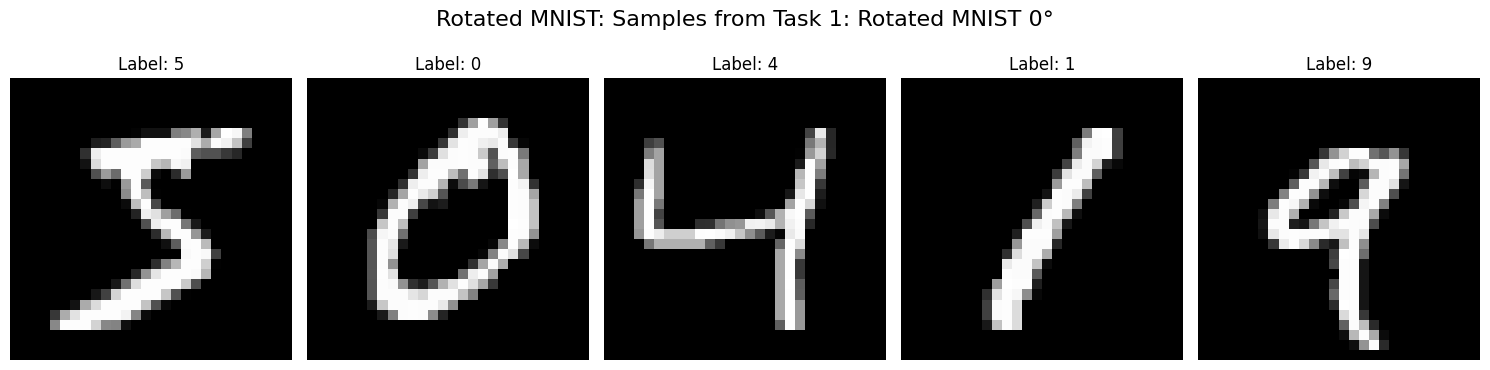

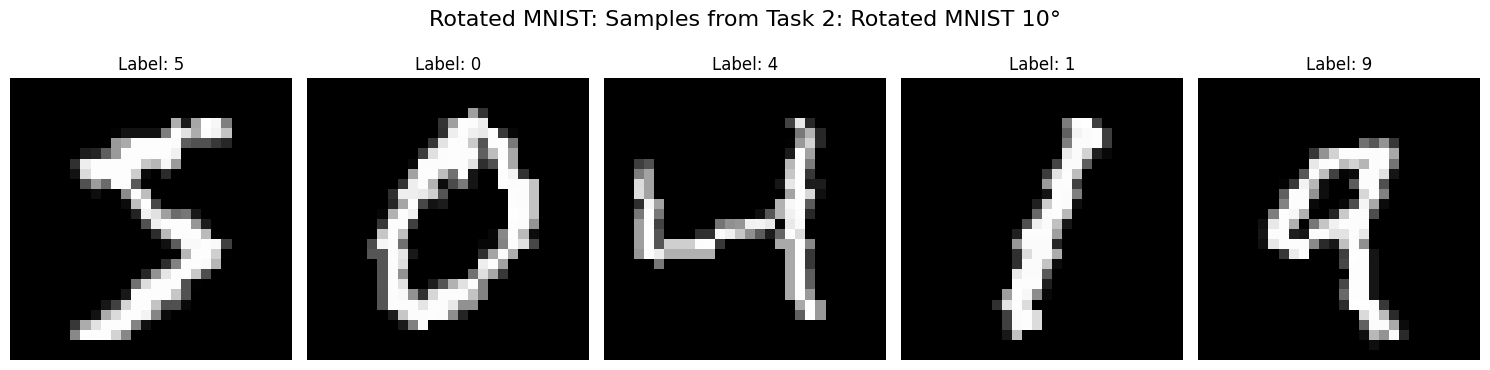

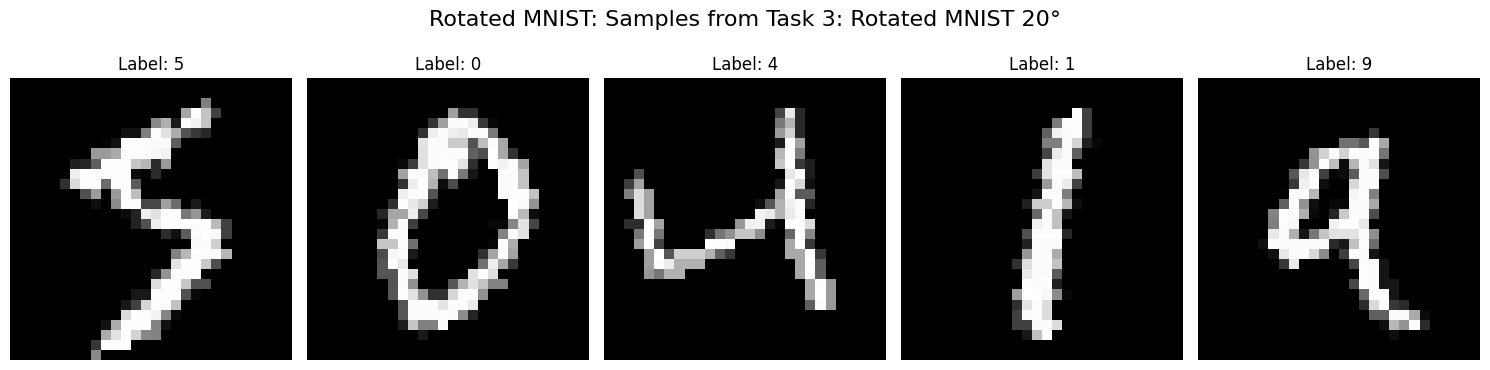

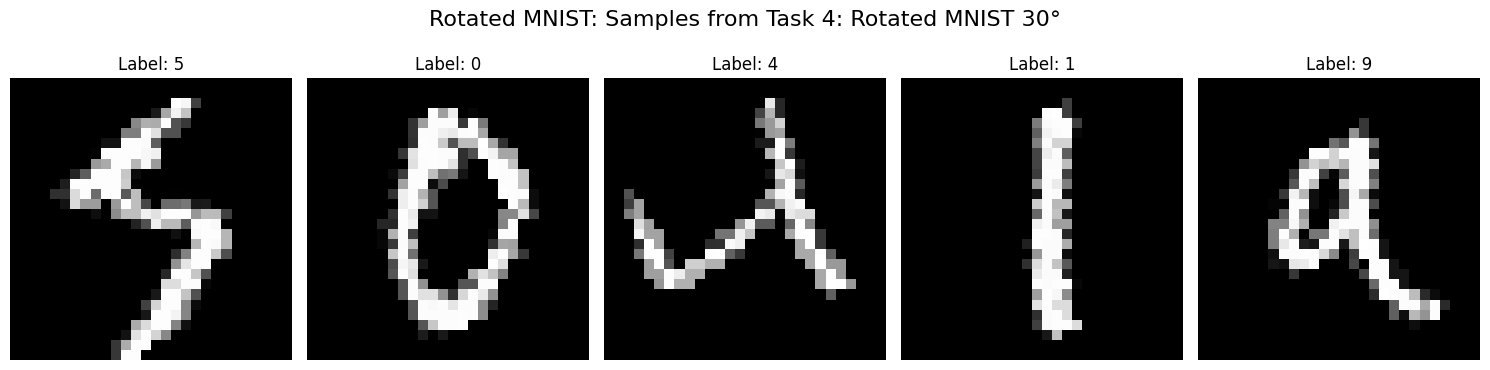

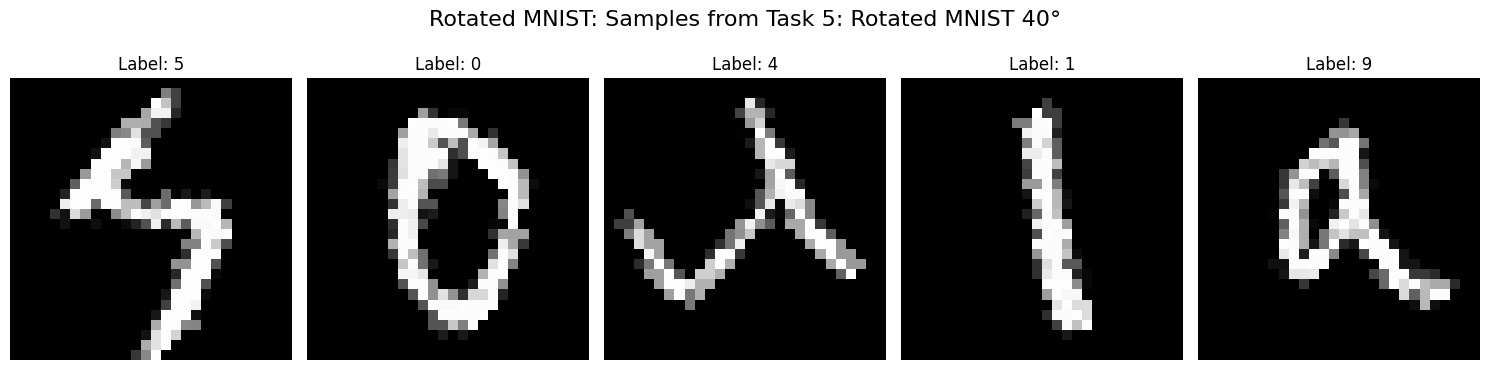

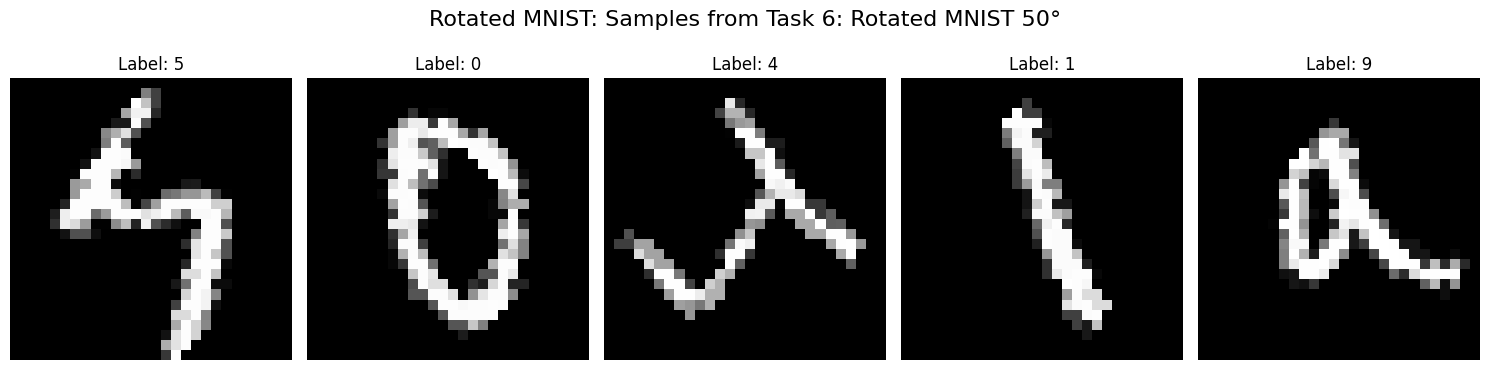

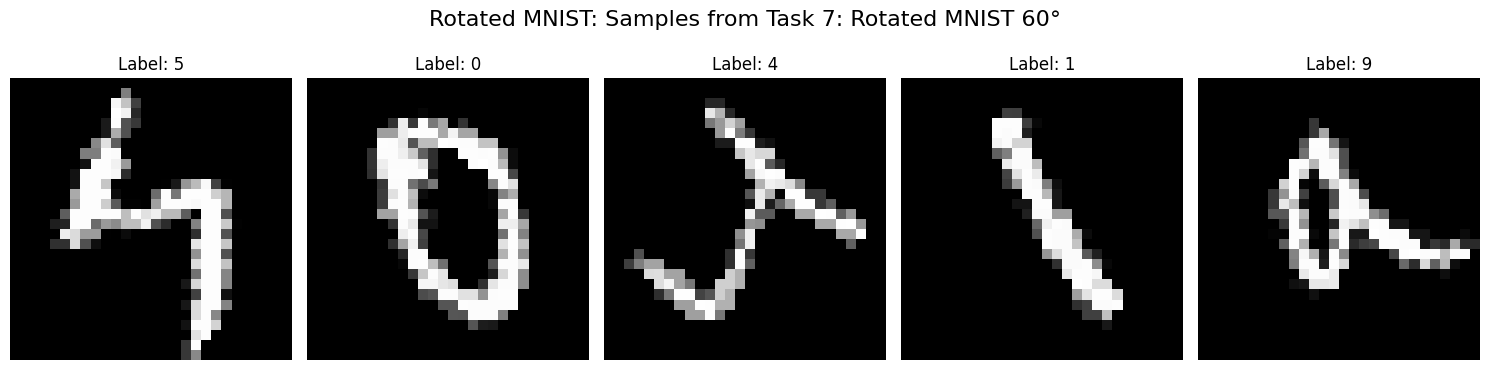

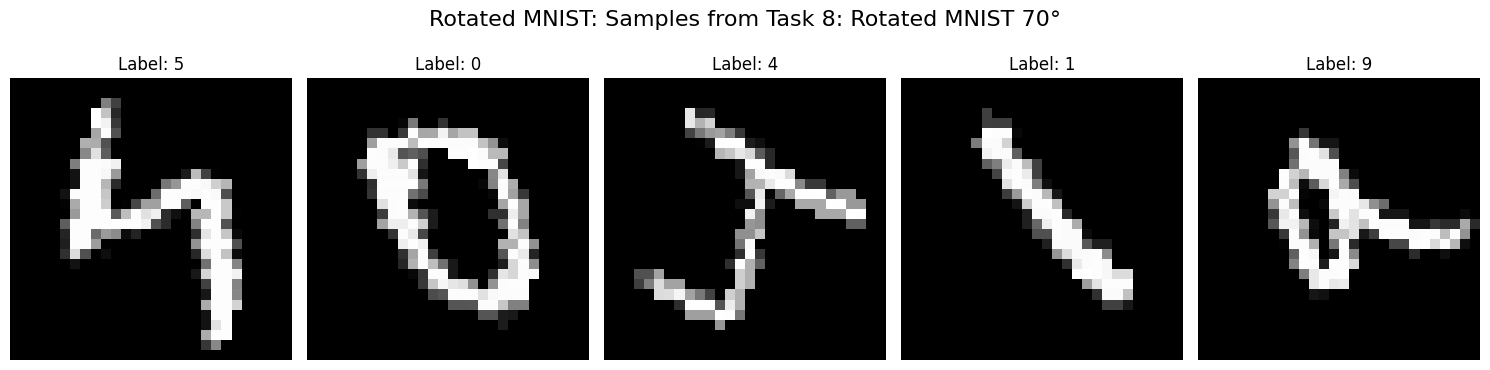

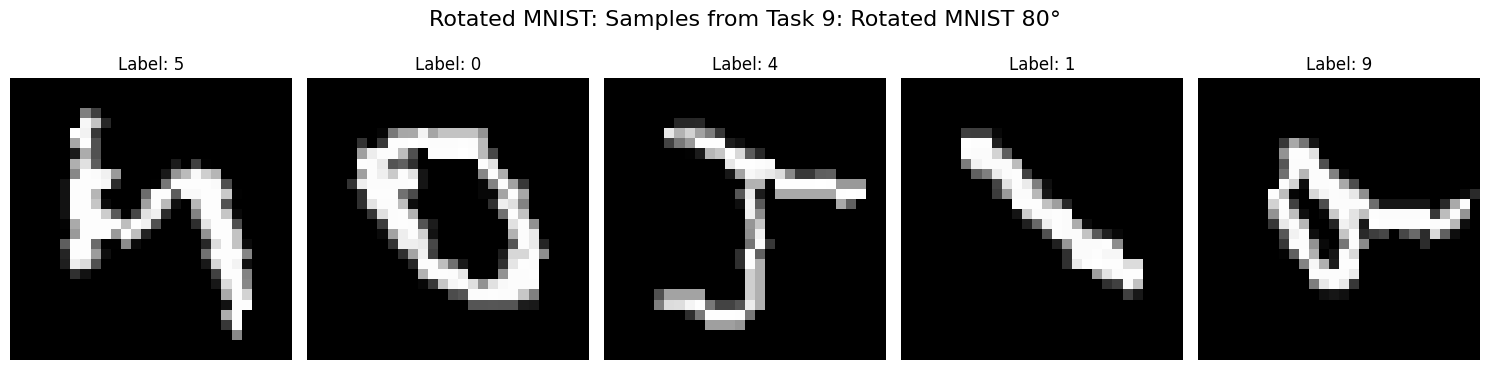

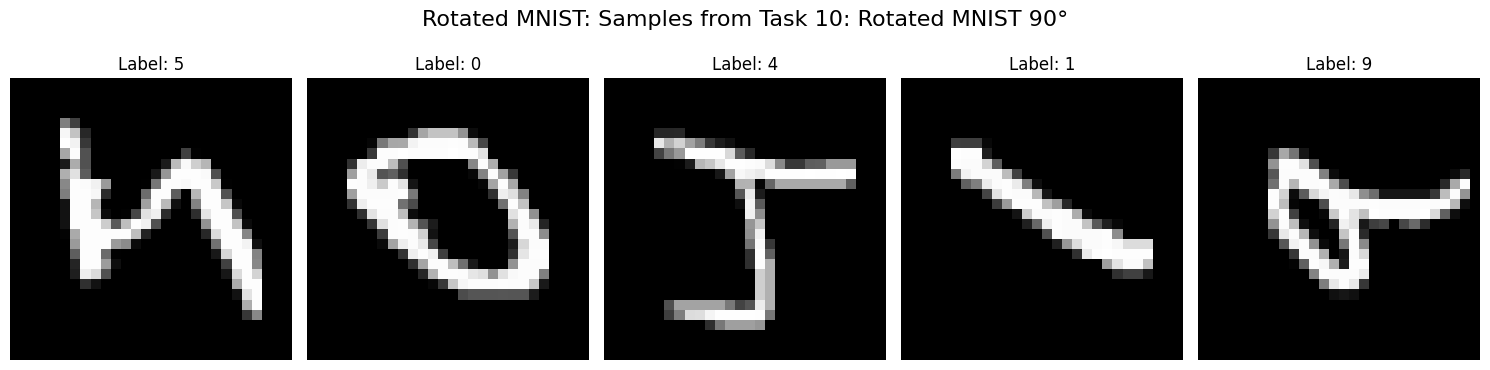

In [34]:
def create_rotated_mnist(task_id, base_angle=0):
    rotation_angle = base_angle + 10 * (task_id - 1)  # Fixed rotation for task
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: transforms.functional.rotate(x, angle=rotation_angle))
    ])
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    return train_dataset, test_dataset

# Generate ten tasks of Rotated MNIST
rot_tasks = [
    Task(
        name=f"Task {i}: Rotated MNIST {10 * (i - 1)}°",
        train=create_rotated_mnist(i)[0],
        test=create_rotated_mnist(i)[1]
    )
    for i in range(1, 11)
]

# Visualize samples from each task
for task in rot_tasks:
    loader = DataLoader(task.train, batch_size=5, shuffle=False)
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 4))
    for j in range(5):
        axes[j].imshow(images[j].squeeze(0), cmap="gray")
        axes[j].set_title(f"Label: {labels[j].item()}")
        axes[j].axis("off")
    
    fig.suptitle(f"Rotated MNIST: Samples from {task.name}", fontsize=16)
    fig.tight_layout()

    plt.show()

### Add the model

The paper proposes a fully connected network (FCN)

They don't mention the size of the validation set, should we just take 20% ?

In [35]:
class Fcn(nn.Module):
    def __init__(self, num_hidden_layers, hidden_size, dropout=False):
        super(Fcn, self).__init__()
        layers = [torch.nn.Flatten()] # Flatten the input tensor for fcn
        
        # MNIST image flattened vector to first hidden layer
        layers.append(nn.Linear(28*28, hidden_size))
        layers.append(nn.ReLU())
        if dropout:
            layers.append(nn.Dropout(p=0.2))
        
        # hidden layers 
        # NOTE: not entirely sure if this is what they ment by hidden layers, my interpretation is
        # that they want the same number of fc layers here as they said in the paper + separate input and output layers...
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            if dropout:
                layers.append(nn.Dropout(p=0.5))
        
        # NOTE: maybe this layer should be removed and the last one of the above should already map to 10 classes? (I don't think so)
        # output layer (map to 10 classes for MNIST)
        layers.append(nn.Linear(hidden_size, 10))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Function ot train the model
# Add early stopping
# also add loss as optimizer I think to be able to do EWC...
def train_sequential_tasks(model, train_tasks, optimizer, num_epochs=10, early_stopping=False, l2_reg = 0.0):
    criterion = nn.CrossEntropyLoss()

    n_tasks = len(train_tasks)

    train_loaders = [DataLoader(task.train, batch_size=64, shuffle=True) for task in train_tasks]

    train_accuracies = np.zeros((n_tasks, n_tasks * num_epochs))

    # Sequentially train on tasks
    for i, train_loader in enumerate(train_loaders):
        print(f"Training on Task {i + 1}/{len(train_tasks)}")

        for epoch in range(num_epochs):
            model.train()
            correct = 0
            total = 0

            # Training on current task
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                loss = criterion(outputs, labels)

                if l2_reg > 0 and i > 0:
                    l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                    loss += l2_reg * l2_norm

                loss.backward()
                optimizer.step()

            # Store current task accuracy for this epoch
            current_task_accuracy = correct / total
            train_accuracies[i, i * num_epochs + epoch] = current_task_accuracy

            print(f"Epoch {epoch + 1}/{num_epochs}\t Accuracy: {current_task_accuracy:.4f} -> Evaluating on previous tasks...", end=" ")

            # Evaluate performance on all previous tasks
            for j, loader in enumerate(train_loaders[:i]):
                correct = 0
                total = 0
                with torch.no_grad():
                    for images, labels in loader:
                        outputs = model(images)
                        _, predicted = torch.max(outputs, 1)
                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)
                task_accuracy = correct / total
                train_accuracies[j, i * num_epochs + epoch] = task_accuracy

            print("Finished!")

    return train_accuracies


In [36]:
def compute_fisher_information(model, dataloader, criterion):
    fisher_information = {name: torch.zeros_like(param) for name, param in model.named_parameters()}
    model.eval()

    for images, labels in dataloader:
        model.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        for name, param in model.named_parameters():
            fisher_information[name] += param.grad ** 2  # Accumulate squared gradients

    fisher_information = {name: param / len(dataloader) for name, param in fisher_information.items()}
    return fisher_information


In [37]:
def ewc_loss(model, fisher_information, theta_star, lambda_ewc):
    loss = 0
    for name, param in model.named_parameters():
        loss += (fisher_information[name] * (param - theta_star[name]) ** 2).sum()
    return (lambda_ewc / 2) * loss


In [38]:
def train_sequential_tasks_ismail(model, train_tasks, optimizer, num_epochs=10, early_stopping=False, ewc=False):
    lambda_ewc = 1000  # Regularization strength

    criterion = nn.CrossEntropyLoss()

    n_tasks = len(train_tasks)
    train_loaders = []
    val_loaders = []

    # Split train datasets into train and validation sets
    for task in train_tasks: 
        train_size = int(0.8 * len(task.train))  # 80% train, 20% validation
        val_size = len(task.train) - train_size
        train_subset, val_subset = random_split(task.train, [train_size, val_size])
        train_loaders.append(DataLoader(train_subset, batch_size=64, shuffle=True))
        val_loaders.append(DataLoader(val_subset, batch_size=64, shuffle=False))

    train_accuracies = np.zeros((n_tasks, n_tasks * num_epochs))
    val_accuracies = np.zeros((n_tasks, n_tasks * num_epochs))

    best_model_state = None
    best_avg_val_error = float('inf')
    early_stopping_counter = 0
    early_stopping_patience = 5

    # Sequentially train on tasks
    for i, train_loader in enumerate(train_loaders):
        print(f"Training on Task {i + 1}/{len(train_tasks)}")

        if (i > 0) and ewc:
            fisher_information = compute_fisher_information(model, train_loaders[i-1], criterion)
            theta_star = {name: param.clone().detach() for name, param in model.named_parameters()}

        for epoch in range(num_epochs):
            model.train()
            correct_train = 0
            total_train = 0

            # Training on current task
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct_train += (predicted == labels).sum().item()
                total_train += labels.size(0)

                loss = criterion(outputs, labels)
                if (i > 0) and ewc:
                    loss += ewc_loss(model, fisher_information, theta_star, lambda_ewc)
                    
                loss.backward()
                optimizer.step()

            # Store current task accuracy for this epoch
            current_task_accuracy = correct_train / total_train
            train_accuracies[i, i * num_epochs + epoch] = current_task_accuracy

            # Validation on current task
            model.eval()
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for images, labels in val_loaders[i]:
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)
                    correct_val += (predicted == labels).sum().item()
                    total_val += labels.size(0)
            val_accuracy = correct_val / total_val
            val_accuracies[i, i * num_epochs + epoch] = val_accuracy

            print(f"Epoch {epoch + 1}/{num_epochs}\t Train Accuracy: {current_task_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f} -> Evaluating on previous tasks...", end=" ")

            # Evaluate performance on all previous tasks (training)
            for j, loader in enumerate(train_loaders[:i]):
                correct_train_prev = 0
                total_train_prev = 0
                with torch.no_grad():
                    for images, labels in loader:
                        outputs = model(images)
                        _, predicted = torch.max(outputs, 1)
                        correct_train_prev += (predicted == labels).sum().item()
                        total_train_prev += labels.size(0)
                train_accuracies[j, i * num_epochs + epoch] = correct_train_prev / total_train_prev
            
            # Evaluate performance on all previous tasks (validation)
            for j, loader in enumerate(val_loaders[:i]):
                correct_val_prev = 0
                total_val_prev = 0
                with torch.no_grad():
                    for images, labels in loader:
                        outputs = model(images)
                        _, predicted = torch.max(outputs, 1)
                        correct_val_prev += (predicted == labels).sum().item()
                        total_val_prev += labels.size(0)
                val_accuracies[j, i * num_epochs + epoch] = correct_val_prev / total_val_prev            
            
            # NOTE: tell me what you think of the all tasks calculation ? Not sure about it 
            all_tasks_val_accuracy = np.mean(val_accuracies[:, i * num_epochs + epoch])
            print(f"Val Accuracy: {all_tasks_val_accuracy:.4f}, Finished!")

            # Early stopping condition based on validation error (all tasks)
            # NOTE: my interpretation of "Early stopping was implemented by computing the test error on the
            # validation set for all pixel permutations" is that we should use val_accuracies of all tasks
            current_val_error = 1 - all_tasks_val_accuracy
            if current_val_error < best_avg_val_error:
                best_avg_val_error = current_val_error
                best_model_state = model.state_dict().copy()
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if early_stopping and early_stopping_counter > early_stopping_patience:
                print("Early stopping triggered, restoring best model state.")
                model.load_state_dict(best_model_state)
                break

    return train_accuracies, val_accuracies


In [39]:
from torchsummary import summary

model = Fcn(num_hidden_layers=2, hidden_size=400)

summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 400]         314,000
              ReLU-3                  [-1, 400]               0
            Linear-4                  [-1, 400]         160,400
              ReLU-5                  [-1, 400]               0
            Linear-6                   [-1, 10]           4,010
Total params: 478,410
Trainable params: 478,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.82
Estimated Total Size (MB): 1.85
----------------------------------------------------------------


In [40]:
# Try the training with normal SGD and see what happens, takes like 10-12 mins for me
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

num_epochs = 10

train_accuracies = train_sequential_tasks(model, perm_tasks, optimizer, num_epochs=num_epochs)

Training on Task 1/3
Epoch 1/10	 Accuracy: 0.2151 -> Evaluating on previous tasks... Finished!
Epoch 2/10	 Accuracy: 0.4829 -> Evaluating on previous tasks... Finished!
Epoch 3/10	 Accuracy: 0.5752 -> Evaluating on previous tasks... Finished!
Epoch 4/10	 Accuracy: 0.6335 -> Evaluating on previous tasks... Finished!
Epoch 5/10	 Accuracy: 0.6842 -> Evaluating on previous tasks... Finished!
Epoch 6/10	 Accuracy: 0.7308 -> Evaluating on previous tasks... Finished!
Epoch 7/10	 Accuracy: 0.7675 -> Evaluating on previous tasks... Finished!
Epoch 8/10	 Accuracy: 0.7972 -> Evaluating on previous tasks... Finished!
Epoch 9/10	 Accuracy: 0.8166 -> Evaluating on previous tasks... Finished!
Epoch 10/10	 Accuracy: 0.8313 -> Evaluating on previous tasks... Finished!
Training on Task 2/3
Epoch 1/10	 Accuracy: 0.5483 -> Evaluating on previous tasks... Finished!
Epoch 2/10	 Accuracy: 0.7462 -> Evaluating on previous tasks... Finished!
Epoch 3/10	 Accuracy: 0.7990 -> Evaluating on previous tasks... Finis

The increasing all tasks val accuracy is weird no ? 

In [ ]:
# Train with EWC
model = Fcn(num_hidden_layers=2, hidden_size=400)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

num_epochs = 10
train_accuracies_ewc, val_accuracies_ewc = train_sequential_tasks_ismail(model, perm_tasks, optimizer, num_epochs=num_epochs, early_stopping=False, ewc=True)

Training on Task 1/3
Epoch 1/10	 Train Accuracy: 0.0994, Val Accuracy: 0.1237 -> Evaluating on previous tasks... Val Accuracy: 0.0413, Finished!
Epoch 2/10	 Train Accuracy: 0.2336, Val Accuracy: 0.3646 -> Evaluating on previous tasks... Val Accuracy: 0.1215, Finished!
Epoch 3/10	 Train Accuracy: 0.4898, Val Accuracy: 0.5778 -> Evaluating on previous tasks... Val Accuracy: 0.1926, Finished!
Epoch 4/10	 Train Accuracy: 0.6191, Val Accuracy: 0.6512 -> Evaluating on previous tasks... Val Accuracy: 0.2171, Finished!
Epoch 5/10	 Train Accuracy: 0.6595, Val Accuracy: 0.6723 -> Evaluating on previous tasks... Val Accuracy: 0.2241, Finished!
Epoch 6/10	 Train Accuracy: 0.6772, Val Accuracy: 0.6860 -> Evaluating on previous tasks... Val Accuracy: 0.2287, Finished!
Epoch 7/10	 Train Accuracy: 0.6911, Val Accuracy: 0.7018 -> Evaluating on previous tasks... Val Accuracy: 0.2339, Finished!
Epoch 8/10	 Train Accuracy: 0.7089, Val Accuracy: 0.7231 -> Evaluating on previous tasks... Val Accuracy: 0.241

No clue how they manage to get that high accuracy for the first task that quickly in the paper. Maybe they train with original mnist first to get closer?? Also the results are not like suuuper close but ok-ish I think...

### Try with L2 norm:

In [ ]:
# Try the training with L2 norm and see what happens

model = Fcn(num_hidden_layers=2, hidden_size=400)
# they don't specify the weight decay in the paper, so I just chose 1e-3, maybe we should increase...
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-2)

num_epochs = 10

train_accuracies_l2 = train_sequential_tasks(model, perm_tasks, optimizer, num_epochs=num_epochs, l2_reg = 1e-2)

Training on Task 1/3
Epoch 1/20	 Accuracy: 0.2274 -> Evaluating on previous tasks... Finished!
Epoch 2/20	 Accuracy: 0.5093 -> Evaluating on previous tasks... Finished!
Epoch 3/20	 Accuracy: 0.6812 -> Evaluating on previous tasks... Finished!
Epoch 4/20	 Accuracy: 0.7443 -> Evaluating on previous tasks... Finished!
Epoch 5/20	 Accuracy: 0.7973 -> Evaluating on previous tasks... Finished!
Epoch 6/20	 Accuracy: 0.8278 -> Evaluating on previous tasks... Finished!
Epoch 7/20	 Accuracy: 0.8459 -> Evaluating on previous tasks... Finished!
Epoch 8/20	 Accuracy: 0.8602 -> Evaluating on previous tasks... Finished!
Epoch 9/20	 Accuracy: 0.8693 -> Evaluating on previous tasks... Finished!
Epoch 10/20	 Accuracy: 0.8761 -> Evaluating on previous tasks... Finished!
Epoch 11/20	 Accuracy: 0.8810 -> Evaluating on previous tasks... Finished!
Epoch 12/20	 Accuracy: 0.8849 -> Evaluating on previous tasks... Finished!
Epoch 13/20	 Accuracy: 0.8883 -> Evaluating on previous tasks... Finished!
Epoch 14/20	 

## Plot results

Note: 
+ EWC not really working 

+ L2 is looking like SGD should look like and when weight decay is 10-3 it overlaps with the other two curves 

+ Shouldn't we start regularizing with L2 after the first task only? Since the goal is to say in the region near optimal performance for the first task? 

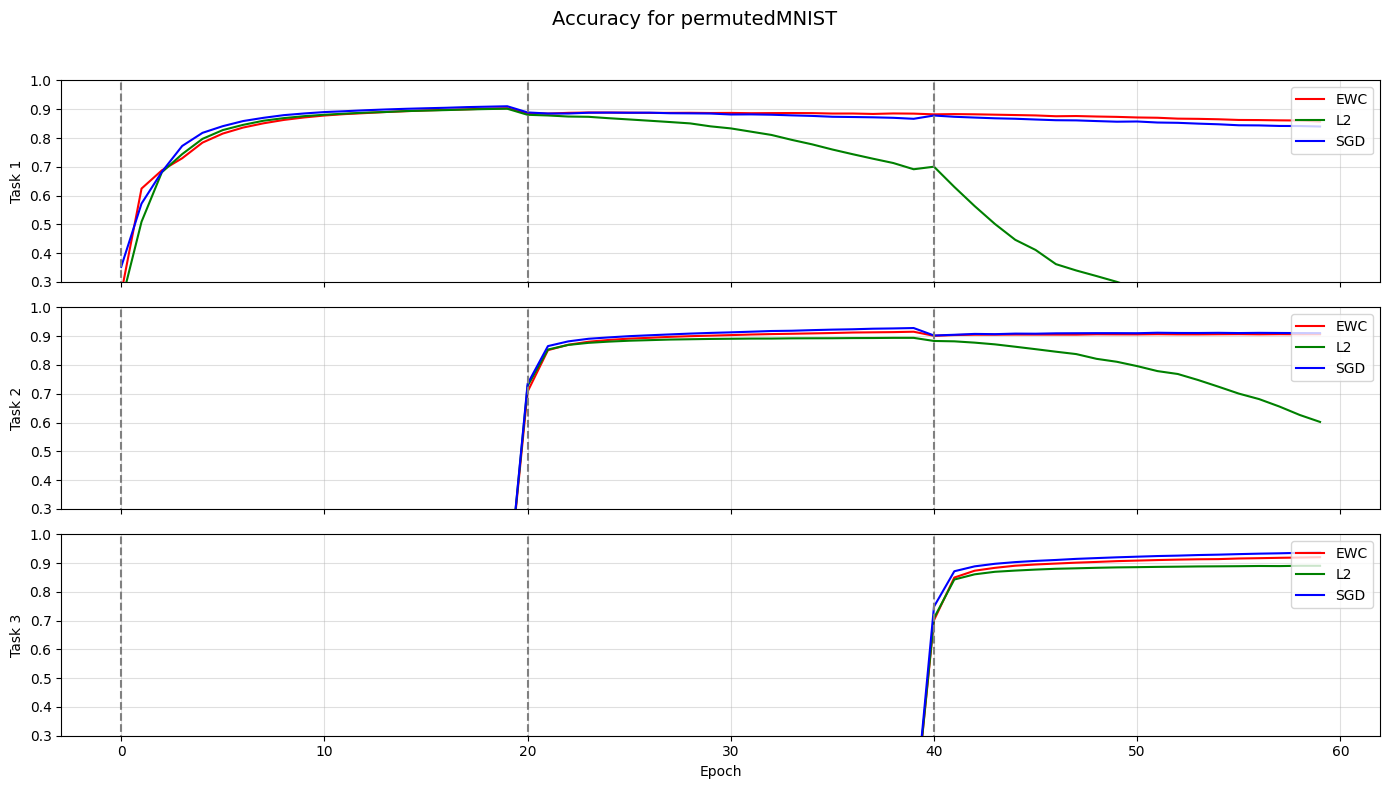

In [ ]:
n_tasks, total_epochs = train_accuracies.shape
fig, axes = plt.subplots(n_tasks, 1, figsize=(14, 8), sharex=True)

for i in range(n_tasks):
  valid_epochs_ewc = np.where(train_accuracies_ewc[i] >= 0)[0]
  axes[i].plot(valid_epochs_ewc, train_accuracies_ewc[i, valid_epochs_ewc], label=f"EWC", color = "red")

  valid_epochs_l2 = np.where(train_accuracies_l2[i] >= 0)[0]
  axes[i].plot(valid_epochs_l2, train_accuracies_l2[i, valid_epochs_l2], label=f"L2", color = "green")

  valid_epochs_sgd = np.where(train_accuracies[i] >= 0)[0]
  axes[i].plot(valid_epochs_sgd, train_accuracies[i, valid_epochs_sgd], label=f"SGD", color = "blue")

  axes[i].vlines(np.arange(0, total_epochs, num_epochs), 0.2, 1.0, linestyles="--", colors="gray")
  axes[i].set_ylabel(f"Task {i + 1}")
  axes[i].legend(loc="upper right", fontsize=10)
  axes[i].set_ylim(0.3, 1.0)
  axes[i].grid(alpha=0.4)

plt.xlabel("Epoch")
fig.suptitle("Accuracy for permutedMNIST", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96]) 

plt.savefig("Figure_2A", dpi=300)
plt.show()